## Step 1: import dependencies

In [50]:
import requests
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Fetch data from github api, extract and load into database

In [51]:
GITHUB_URL = "https://api.github.com/repos/apache/airflow/commits"
DATE_SINCE = "2023-06-01"
DATE_UNTIL = "2023-12-01"

def fetch_commit(github_url, date_since, date_until):
    commits=[]
    params={"since":date_since, "until":date_until}
    while github_url:
        try:
            response = requests.get(github_url, params=params)
            response.raise_for_status()
            data=response.json()
            for commit in data:
                commits.append({
                    "committer_name": commit["commit"]["author"]["name"],
                    "commit_date": commit["commit"]["author"]["date"]
                })
            if 'next' in response.links:
                github_url = response.links["next"]["url"]
            else:
                break
                
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
            break
    return pd.DataFrame(commits)

def transform_date(df):
    df["commit_date"]=pd.to_datetime(df["commit_date"])
    df["day_of_week"] = df["commit_date"].dt.day_name()
    df["hour"]=df["commit_date"].dt.hour

    return df
    
def load_to_db(df,db_url="sqlite:///commits.db"):
    with create_engine(db_url).connect() as connection:
        df.to_sql("commits", con=connection, if_exists="replace", index=False)

def query_db(query, db_url="sqlite:///commits.db"):
    with create_engine(db_url).connect() as connection:
        return pd.read_sql(query, connection)

commits_df = fetch_commit(GITHUB_URL, DATE_SINCE, DATE_UNTIL)
transformed_df=transform_date(commits_df)
load_to_db(transformed_df)

## Question 1: Get the top 5 committers ranked by count of commits and their number of commits.

In [52]:
TOP_COMMITTERS_QUERY="""
SELECT committer_name, COUNT(*) AS commit_count
FROM commits
GROUP BY committer_name
ORDER BY commit_count DESC
LIMIT 5; 
"""
def query_db(query, db_url="sqlite:///commits.db"):
    with create_engine(db_url).connect() as connection:
        return pd.read_sql(query, connection)
        
print("Top 5 Committers:")
print(query_db(TOP_COMMITTERS_QUERY))

Top 5 Committers:
    committer_name  commit_count
0     Jarek Potiuk           406
1    Hussein Awala           204
2    Andrey Anshin           133
3  Miroslav Šedivý           121
4          Wei Lee            88


## Question 2: Committer with the longest commit streak by day.

In [53]:
def get_longest_streak(df):
    df = df.sort_values(by=["committer_name", "commit_date"]) 

    streaks = []
    for committer, group in df.groupby("committer_name"):
        group["date_diff"] = group["commit_date"].diff().dt.days.fillna(1).astype(int)
        group["streak"] = (group["date_diff"] != 1).cumsum() 
        longest_streak = group.groupby("streak").size().max()
        streaks.append({"committer_name": committer, "longest_streak": longest_streak})
    streak_df = pd.DataFrame(streaks)
    return streak_df.sort_values(by="longest_streak", ascending=False).iloc[0]

print(get_longest_streak(transformed_df))

committer_name    Akash Sharma
longest_streak               4
Name: 8, dtype: object


## Question 3: A heatmap of number of commits count by all users by day of the week and by 3 hour blocks.

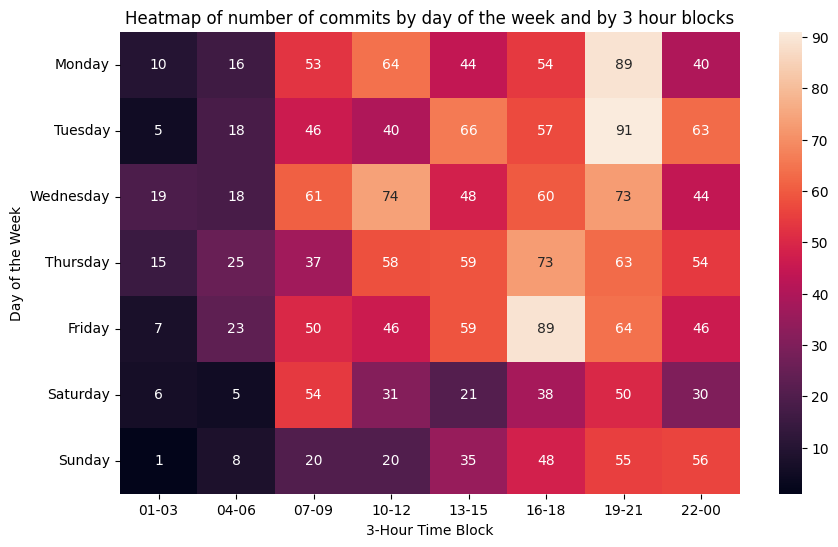

In [54]:
HEAT_MAP_QUERY = """
SELECT 
    day_of_week, 
    (hour / 3) as three_hour_block,
    COUNT(*) as commit_count
FROM commits
GROUP BY day_of_week, three_hour_block;
"""
heatmap_data = query_db(HEAT_MAP_QUERY)
heatmap_data["three_hour_block"] = heatmap_data["three_hour_block"].astype(int)

hour_labels = ["01-03", "04-06", "07-09", "10-12", "13-15", "16-18", "19-21", "22-00"]
heatmap_data["three_hour_block_label"] = heatmap_data["three_hour_block"].apply(lambda x: hour_labels[x])

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data["day_of_week"] = pd.Categorical(heatmap_data["day_of_week"], categories=day_order, ordered=True)

heatmap_matrix = heatmap_data.pivot(index="day_of_week", columns="three_hour_block_label", values="commit_count").fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_matrix, annot=True)
plt.title("Heatmap of number of commits by day of the week and by 3 hour blocks")
plt.xlabel("3-Hour Time Block")
plt.ylabel("Day of the Week")
plt.show()